# 非线性拟合 — Theis 公式

Theis 公式

$$
s= \frac{Q}{4\pi T}\int_u^\infty\frac{1}{y}e^{-y}dy=\frac{Q}{4\pi T}W(u)\tag{1}
$$

取初始参数 $T_0$，$S_0$，降深 $s$ 的泰勒级数展开为

$$
s(T,S)=s(T_0,S_0)+\frac{\partial{s}}{\partial{S}}\Bigg|_{S=S_0}\Delta{S}+\frac{\partial{s}}{\partial{T}}\Bigg|_{T=T_0}\Delta{T}+O(\Delta{T}^2+\Delta{S}^2)
\tag{2}
$$

式中，$\Delta{T} = T-T_0,\Delta{S}=S-S_0$。因为 $\frac{\partial{u}}{\partial{S}}=\frac{u}{S}, \frac{\partial{u}}{\partial{T}}=-\frac{u}{T}$ ，得

$$
\frac{\partial{s}}{\partial{S}} = -\frac{Q}{4{\pi}T}\frac{e^{-u}}{S},\quad
\frac{\partial{s}}{\partial{T}} = \frac{Q}{4{\pi}T^2}\left[-W(u)+e^{-u}\right]
$$

记

$$
a=\left.\frac{\partial{s}}{\partial{S}}\right|_{S=S_0},\quad
b=\left.\frac{\partial{s}}{\partial{T}}\right|_{T=T_0},\quad
c=s(T_0,S_0)
\tag{3}
$$

忽略高阶无穷小，(2) 式可写为

$$
\hat s =c +a\cdot\Delta S + b\cdot \Delta T
\tag{4}
$$

式 (4) 以 $(\Delta T, \Delta S)$ 为未知系数, $\hat s$ 为 $s$ 的预测值，$a,b,c$ 根据初始参数（$T_0,S_0$）及观测时间计算。由此式可构造最小二乘问题求参。

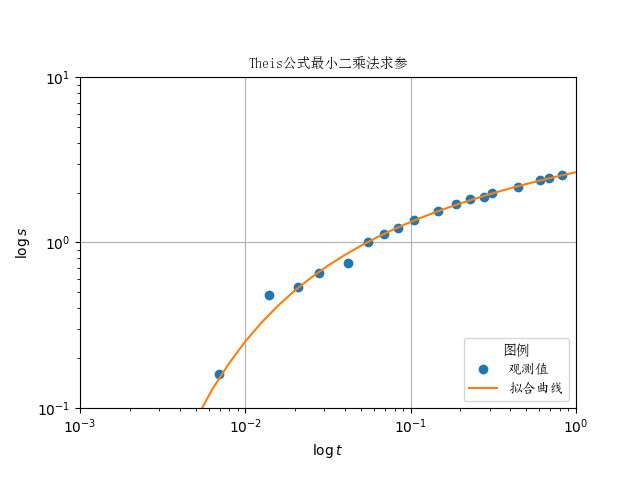

循环次数 = 3
T = 193.38 m^2/d, S = 3.1374e-04
RSS = 1.6944e-01


In [1]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1

# 控制小数的显示精度
np.set_printoptions(precision=4)


def calc_u(p, r, t):   # 计算变量 u
    S, T = p
    return r**2*S/4/T/t

# 定义井函数计算方法，可用 scipy.special.exp1 计算. 
# 也可用多项式逼近的方法计算井函数
def theis_drawdown(p, t, Q, r):  # 计算降深
    S, T = p
    u = calc_u(p, r, t)
    s_theis = Q/4/np.pi/T*exp1(u)
    return s_theis

def theis_Dfun(p, t, s, Q, r):  # 计算 ds/dT,ds/S
    """Calculate and return ds/dS and ds/dT for the Theis equation.
    The parameters S, T are packed into the tuple p.
    """
    S, T = p
    u = calc_u(p, r, t)
    dsdS = -Q/4/np.pi/T/S*np.exp(-u)
    dsdT = Q/4/np.pi/T**2*(-exp1(u) + np.exp(-u))
    return np.array((-dsdS, -dsdT)).T   # 返回负梯度

def theis_resid(p, t, s, Q, r): # 计算降深预测误差
    S, T = p
    return s - theis_drawdown(p, t, Q, r)

# 抽水量 Q, 观测孔位置 r
r = 125.0  # m, 15#孔位置
Q = 1440   # m^3/d

#  从文件读数据到数组 t, s 中, 文件和当前脚本在同一目录下不用写具体路径
fname = 'S-T-Data.txt'
data = np.loadtxt(fname, delimiter=',')

# 2#孔降深 data[0:,1]；15#孔降深 data[0:,2]
t = data[0:, 0]/1440
s = data[0:, 2]

# 取数组长度
n = len(t)

# 初始参数怎么取？随机取两点，用 Jacob 两点公式计算。
np.random.seed()
i1 = np.random.randint(int(n/2))
i2 = np.random.randint(int(n/2), n - 1)
t1 = t[i1]
t2 = t[i2]
s1 = s[i1]
s2 = s[i2]
kk = (s1 - s2)/np.log10(t1/t2)
T0 = 0.183*Q/kk
S0 = 2.25*T0*t1/r**2/np.float_power(10, s1/kk)

p = S0, T0 
S, T = p

# 循环计数器
j = 0
while True:
    c = theis_drawdown(p, t, Q, r)
    a = theis_Dfun(p, t, s, Q, r)[:, 0]
    b = theis_Dfun(p, t, s, Q, r)[:, 1]
    X = np.vstack([a, b]).T  # 形成系数矩阵
    # 调用 np.linalg.solve
    beta = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, c - s))
    DS = beta[0]
    DT = beta[1]
  
    while True:
        if S + DS < 0:    # 步长太大导致参数为负数，不合理！
            DS = DS/2.0  # 减小步长
        else:
            break 
    while True:
        if T + DT < 0:    # 步长太大导致参数为负数，不合理！
            DT = DT/2.0  # 减小步长
        else:
            break
    j = j + 1  # 循环计数器
    if j > 1000:  # 循环次数多，程序可能有错误
        print('  循环超过 1000 次，请先检查程序再运行！')
        break
    if (abs(DT) < 1.0E-6) or (abs(DS) < 1.0e-8):  # 判断计算误差
        break
    # 新参数值
    p = S + DS, T + DT
    S, T = p

# 生成绘图数据
x0 =[i for i in np.arange(-3, 0.1, 0.1)]
x =np.power(10, x0)
y = theis_drawdown(p, x, Q, r)
plt.style.use('default')
fig, ax = plt.subplots(dpi=100)
ax.grid(True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001, 1)
ax.set_ylim(0.1, 10)
ax.set_aspect(1)
ax.plot(t, s, 'o', label='观测值')
ax.plot(x, y, label='拟合曲线')
plt.xlabel(r'$\log t$') 
plt.ylabel(r'$\log s$')

plt.legend(
    prop={'family': 'Kaiti', 'size': 10},
    loc=4,title="图例",
    title_fontproperties={'family': 'Simsun'})
# 指定图标题，显示中文
ax.set_title("Theis公式最小二乘法求参", fontproperties={'family': 'Simsun'})  

plt.show()

# 显示最终结果
print('循环次数 = {}'.format(j))
print('T = {:.2f} m^2/d,'.format(T), 'S = {:.4e}'.format(S))
print('RSS = {:.4e}'.format(np.sqrt(np.sum((c - s)**2))))

> **注意**： 程序设计需要考虑以下问题：
>
> - 最小二乘法得出的 $(T_0+\Delta T,S_0+\Delta S)$ 有时为不合理的负值，用二分法缩小步长可保证参数为正值；
> - 最小二乘法只是在初值的基础上进行了一步优化。为得到最优参数，需用得出的参数作为新的初值重复计算；
> - 初值对最终结果有影响。选取两组观测数据按 Jacob 公式可计算出合理的参数初值。